# Creating a wildtype (WT / PD0), and Parkinson degeneration (PD2) network

In the directory ```network_path``` we have three sub directories ```PD0```, ```PD2-ref``` and ```PD2```. In order to generate the ```PD2``` network, we degenerate the ```PD0``` network by swapping the WT morphologies for the PD2 morphologies. In addition a subset of the synapses in the ```PD2-ref``` network are added to compensate for differences in pruning.

We need to specify a ```connection_override``` file. The difference compared to the standard connection file is that it contains ```recovery``` information, i.e. the fraction of synapses from the ```PD2-ref``` network that should be added to the ```PD2``` network.

The ```rc``` object is a ```ipyparallel``` ```RemoteClient``` object for parallel execution.

If you want to remap external input that was removed to a new position, then use ```remap_removed_input = True```

In [1]:
import os

network_path = os.path.join("networks","PD-example-2")

network_path_pd0 = os.path.join(network_path, "PD0")
network_path_pd2_ref = os.path.join(network_path, "PD2-ref")
network_path_pd2 = os.path.join(network_path, "PD2")

network_size = 200
input_config = "test-input.json"  # Only background input will be used in this example

snudda_data_base_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "Parkinson", "20220225")
snudda_data_pd0 = os.path.join(snudda_data_base_path, "PD0")
snudda_data_pd2 = os.path.join(snudda_data_base_path, "PD2")

network_config_pd0 = os.path.join(snudda_data_base_path, "connectivity", "network-config.json")
network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-synapse-recovery.json")

input_pd0 = os.path.join(network_path_pd0, "input-spikes.hdf5")
input_pd2 = os.path.join(network_path_pd2, "input-spikes.hdf5")

# Do we want to remap removed input?
remap_removed_input = True
remapped_fraction = 0.7

rc = None

## First generate the WT reference network

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd0, random_seed=123456, snudda_data=snudda_data_pd0,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd0)

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd0, verbose=False, rc=rc)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd0, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd0, rc=rc)
sp.prune()

In [ ]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path_pd0, 
                 input_config_file=input_config,
                 verbose=False)
si.generate()

## Generate a PD2 reference network

This network will not have the same synapses as the WT, but it is used in order to add "recovery synapses" to compensate for part of the degeneration.

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd2_ref, random_seed=123456, snudda_data=snudda_data_pd2,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd2)

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd2_ref, verbose=False, rc=rc)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd2_ref, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd2_ref, rc=rc)
sp.prune()

## Degenerating the PD0 network to get PD2 network

In [2]:
network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")

from snudda.utils.swap_to_degenerated_morphologies_extended import SwapToDegeneratedMorphologiesExtended
swap = SwapToDegeneratedMorphologiesExtended(original_network_file=network_file_pd0,
                                             updated_network_file=network_file_pd2_ref,
                                             output_network_file=network_file_pd2,
                                             original_snudda_data_dir=snudda_data_pd0,
                                             updated_snudda_data_dir=snudda_data_pd2,
                                             original_input_file=input_pd0,
                                             output_input_file=input_pd2)
swap.write_new_network_file()
swap.write_new_input_file(remap_removed_input=remap_removed_input, remapped_fraction=remapped_fraction)
swap.close()

Loading 200 neurons with 20644 synapses and 3 gap junctions
Loading 200 neurons with 9071 synapses and 3 gap junctions
Writing new network to networks/PD-example-2/PD2/network-synapses.hdf5
Loading synapses into memory.
20644 / 20644
Processing neuron 0
Processing neuron 100
No axon for neuron ChIN_0 (112)
No axon for neuron ChIN_0 (119)
No axon for neuron LTS_8 (173)
Synapse degeneration recovery...
Running post degeneration pruning of synapses
13483 / 13483
Unable to compensate for 594.6 degenerated synapses.
Post pruning. Keeping 9358/13483 (69.406%)
Keeping 9358 out of 20644 synapses (45.330 %)
Loading synapses into memory.
3 / 3
Keeping 3 out of 3 gap junctions (100.000 %)
Writing new input data to networks/PD-example-2/PD2/input-spikes.hdf5
Processed input to dSPN_6 (0), keeping 105 out of 200 inputs (plus remapping 66 inputs)(52.50 %) (33.00 % remapped)
Processed input to dSPN_17 (1), keeping 57 out of 200 inputs (plus remapping 101 inputs)(28.50 %) (50.50 % remapped)
Processed 

## Plotting of a degenerated neuron

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD0 from networks/PD-example-2/PD0/network-config.json
Loading 200 neurons with 20644 synapses and 3 gap junctions
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD2 from networks/PD-example-2/PD2/network-synapses.hdf5
Loading 200 neurons with 9358 synapses and 3 gap junctions
Plotting 200 external synapses
Plotting 180 external synapses
Figure written: networks/PD-example-2/PD2/figures/input-to-50-iSPN_21-and-internal-synapses.png


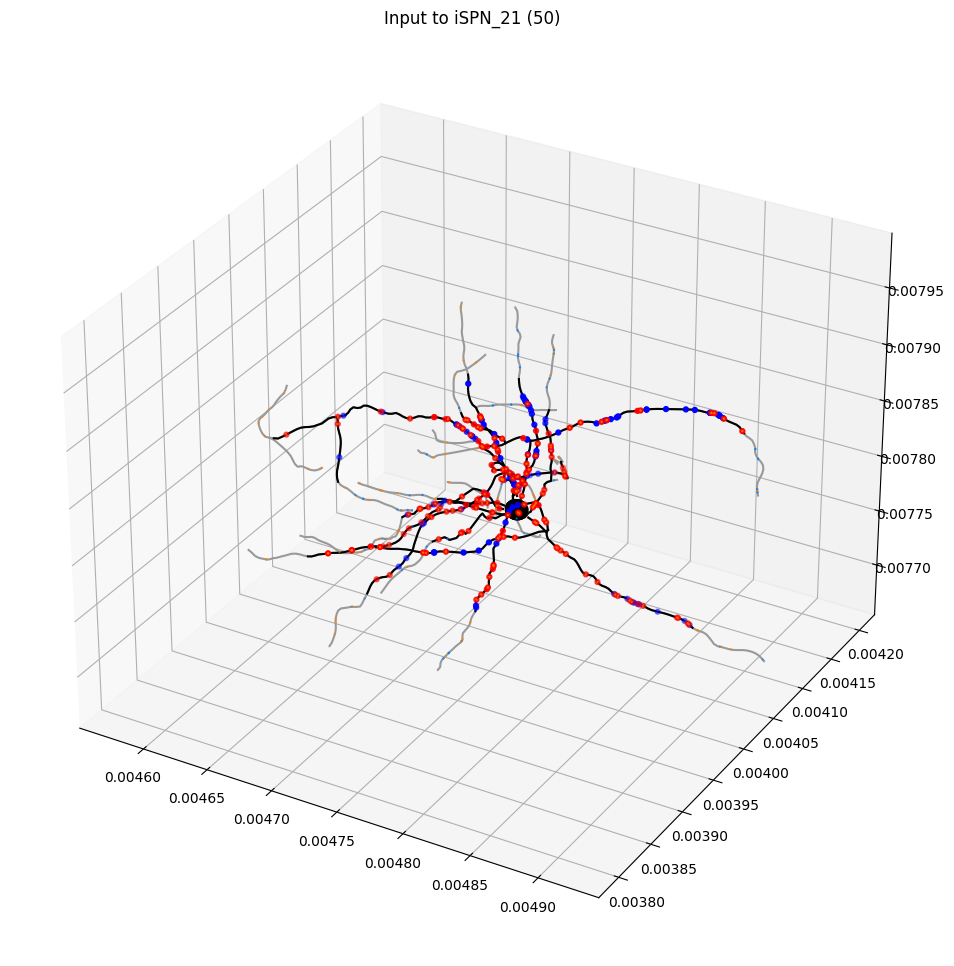

In [3]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2)
plot_neuron_id = 50
pd.plot_neuron(neuron_id=plot_neuron_id, figure_size=(12,12), show_internal_synapses=True)

In [4]:
from snudda.analyse.analyse_input import AnalyseInput

pd0_input_info = AnalyseInput(input_file=input_pd0, network_path=network_path_pd0)
pd2_input_info = AnalyseInput(input_file=input_pd2, network_path=network_path_pd2)

Loading 200 neurons with 20644 synapses and 3 gap junctions
Loading 200 neurons with 9358 synapses and 3 gap junctions


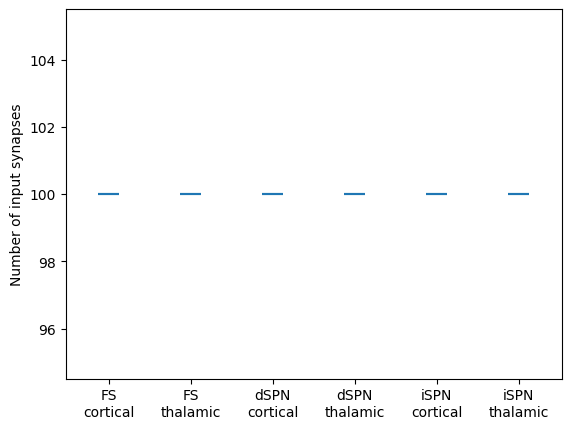

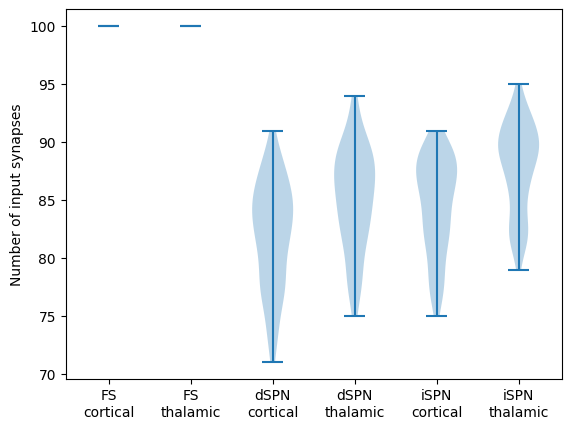

In [5]:
pd0_input_info.plot_input_count("PD0-input_example.png")
pd2_input_info.plot_input_count("PD2-input_example.png")